In [1]:
# import sys
# sys.path.append('../data')
# print each command: 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
# General DS libraries we are going to need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Importing our base model
# [REDACTED ML MODEL USED]

# Imports for working with our large dataset
from sklearn.utils.random import sample_without_replacement
from sklearn.model_selection import train_test_split

# We need those for data manipulation and getting our features ready for the model
from sklearn.preprocessing import OneHotEncoder, Normalizer, Binarizer
from sklearn.compose import make_column_transformer

# These can be used to measure our model's performance
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

# Ignore DataFrame assignment warnings
pd.options.mode.chained_assignment = None

pd.options.display.float_format = '{:,.2f}'.format

In [3]:
n_neighbors = 7 
group_name = "first" 
samples_num = 100000 
n_jobs = 1 
path_prefix = "./data"
nrows=2e6

In [4]:
%%time
train_accounts = pd.read_csv('{}/train_accounts.csv'.format(path_prefix), low_memory=False, parse_dates=['created_at'], infer_datetime_format=True, nrows=nrows)
train_users = pd.read_csv('{}/train_users.csv'.format(path_prefix), low_memory=False, parse_dates=['created_at'], infer_datetime_format=True, nrows=nrows)
train_events = pd.read_csv('{}/train_events.csv'.format(path_prefix), low_memory=False, parse_dates=['date'], infer_datetime_format=True, date_parser=(lambda x: pd.to_datetime(x, errors='coerce')), nrows=nrows)
train_subscriptions = pd.read_csv('{}/train_subscriptions.csv'.format(path_prefix), low_memory=False, parse_dates=['event_happened_at'], infer_datetime_format=True, nrows=nrows)

Wall time: 22.1 s


In [5]:
%%time
test_accounts = pd.read_csv('{}/test_accounts.csv'.format(path_prefix), low_memory=False, parse_dates=['created_at'], infer_datetime_format=True)
test_users = pd.read_csv('{}/test_users.csv'.format(path_prefix), low_memory=False, parse_dates=['created_at'], infer_datetime_format=True)
test_events = pd.read_csv('{}/test_events.csv'.format(path_prefix), low_memory=False, parse_dates=['date'], infer_datetime_format=True, date_parser=(lambda x: pd.to_datetime(x, errors='coerce')))
test_subscriptions = pd.read_csv('{}/test_subscriptions.csv'.format(path_prefix), low_memory=False, parse_dates=['event_happened_at'], infer_datetime_format=True)

Wall time: 3.38 s


In [6]:
accounts = pd.concat([train_accounts, test_accounts],sort=False)
users = pd.concat([train_users, test_users],sort=False)
events = pd.concat([train_events, test_events],sort=False)
subscriptions = pd.concat([train_subscriptions, test_subscriptions],sort=False)

In [55]:
train_accounts.groupby(by=['lead_score']).count()['account_id']

lead_score
0    1328072
1      33906
Name: account_id, dtype: int64

In [67]:
33906/(1328072+33906)
X_train, X_test, y_train, y_test = train_test_split(train_accounts.drop('lead_score',axis=1), train_accounts['lead_score'], test_size=0.05)

0.024894675244387206

In [72]:
y_train.sum()/len(y_train)
y_test.sum()

0.024836943794589755

1770

# Feature engineering: 'country', 'time_diff', 'region'

In [166]:
x = accounts[['account_id','country', 'time_diff', 'region','lead_score']]
x['country_counts'] = x.groupby('country')['country'].transform('count')
x['region_counts'] = x.groupby('region')['region'].transform('count')

In [158]:
x.head()
x.nunique()
x.describe()
print('nan values percentage:')
x.isna().sum()/len(x)*100

,account_id,country,time_diff,region,country_counts,region_counts
0,1.00,AU,11.00,New South Wales,"51,373.00","18,016.00"
1,2.00,US,nan,New Jersey,"331,020.00","14,239.00"
2,3.00,US,-6.00,Louisiana,"331,020.00","2,361.00"
3,4.00,IL,nan,Tel Aviv,"15,093.00","7,601.00"
4,5.00,US,-5.00,North Carolina,"331,020.00","8,513.00"


account_id        1433659
country               236
time_diff              41
region               3601
country_counts        175
region_counts         656
dtype: int64

,account_id,time_diff,country_counts,region_counts
count,"1,433,661.00","1,191,655.00","1,412,954.00","1,340,595.00"
mean,"716,829.94",-1.44,"123,472.91","12,192.86"
std,"413,861.68",4.72,"124,294.70","15,064.11"
min,1.00,-12.00,1.00,1.00
25%,"358,416.00",-5.00,"27,073.00","1,640.00"
50%,"716,830.00",-3.00,"67,655.00","6,652.00"
75%,"1,075,244.00",2.00,"163,931.00","15,065.00"
max,"1,433,659.00",14.00,"331,020.00","56,912.00"


nan values percentage:


account_id        0.00
country           1.44
time_diff        16.88
region            6.49
country_counts    1.44
region_counts     6.49
dtype: float64

In [214]:
time_diff_no_country = (x['time_diff'].notnull() & x['country'].isna())
time_diff_no_country.mean()*100

x.loc[(time_diff_no_country),['account_id','time_diff','country']]


x2

0.4768909805037592

,account_id,time_diff,country
41,43.00,1.00,NaN
130,139.00,1.00,NaN
163,174.00,-5.00,NaN
201,213.00,-5.00,NaN
227,242.00,11.00,NaN
...,...,...,...
61147,"1,224,146.00",-3.00,NaN
61217,"1,225,535.00",2.00,NaN
61828,"1,236,909.00",-5.00,NaN
63406,"1,268,203.00",2.00,NaN


""


,country,train,test
time_diff,,,
-12.00,188,178.00,10.00
-11.00,68,63.00,5.00
-10.00,1267,"1,197.00",70.00
-9.50,1,nan,1.00
-9.00,261,248.00,13.00
-8.00,27114,"25,761.00","1,353.00"
-7.00,60488,"57,483.00","3,005.00"
-6.00,103160,"97,960.00","5,200.00"
-5.00,230699,"219,260.00","11,439.00"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000002F1BAE76D8>,
      dtype=object)

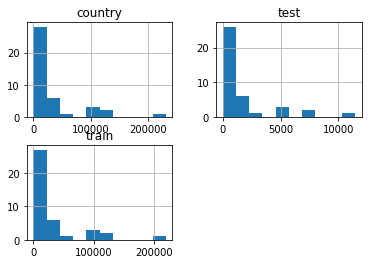

In [229]:
# x2=pd.DataFrame()
x2=accounts[['country','time_diff']].groupby(by='time_diff').count()
x2['train']=train_accounts[['country','time_diff']].groupby(by='time_diff').count()
x2['test']=test_accounts[['country','time_diff']].groupby(by='time_diff').count()
# x2/=x2.sum()
x2
x2.hist()
plt.show()

all     1,412,954.00
train   1,342,302.00
test       70,652.00
dtype: float64

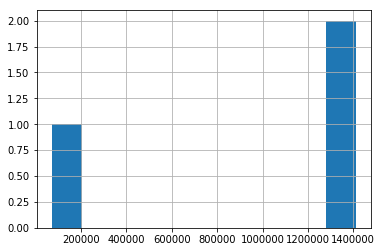

In [273]:
x2=pd.DataFrame()
x2['all']=accounts.groupby('country')['country'].count()
# groupby('country')['country'].transform('count')
x2['train']=train_accounts.groupby('country')['country'].count()
x2['test']=test_accounts.groupby('country')['country'].count()
x2=x2.sum()
x2
x2.hist(density=False)
plt.show()

In [293]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2890269 entries, 0 to 890268
Data columns (total 23 columns):
date                        datetime64[ns]
user_id                     float64
account_id                  float64
total_events                float64
column_events               int64
board_events                int64
num_of_boards               int64
count_kind_columns          int64
content_events              int64
group_events                int64
invite_events               int64
import_events               int64
notification_events         int64
new_entry_events            int64
payment_events              int64
inbox_events                int64
communicating_events        int64
non_communicating_events    float64
web_events                  int64
ios_events                  int64
android_events              int64
desktop_app_events          int64
empty_events                int64
dtypes: datetime64[ns](1), float64(4), int64(18)
memory usage: 529.2 MB


In [404]:
x=accounts.set_index('account_id')
y=events.groupby('account_id')['total_events'].sum()
z1=x.join(y)
# z1['total_events']=z1['total_events'].fillna(0)
z1=z1.fillna(0)
# z=z.drop('user_id',axis=1)

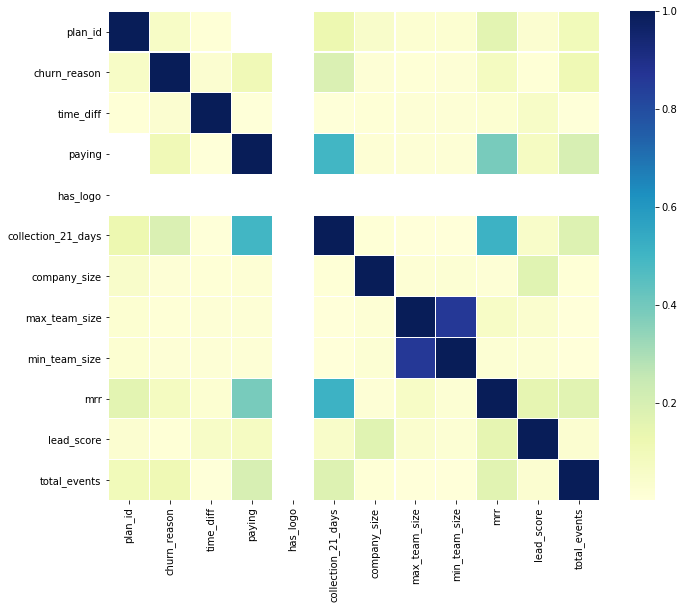

In [411]:
corrmat = z1.select_dtypes('number').corr()
f, ax = plt.subplots(figsize = (11,9))
sns.heatmap(abs(corrmat), ax=ax, cmap='YlGnBu', linewidths= 0.1)

In [412]:
x=accounts.set_index('account_id')
y=subscriptions.groupby('account_id')['invoice_charge_amount_usd','mrr_gain'].sum()
# y=y.drop(['subscription_id','plan_id'],axis=1)
z2=x.join(y)
# z2[y.columns.values]=z2[y.columns.values].fillna(0)
z2=z2.fillna(0)

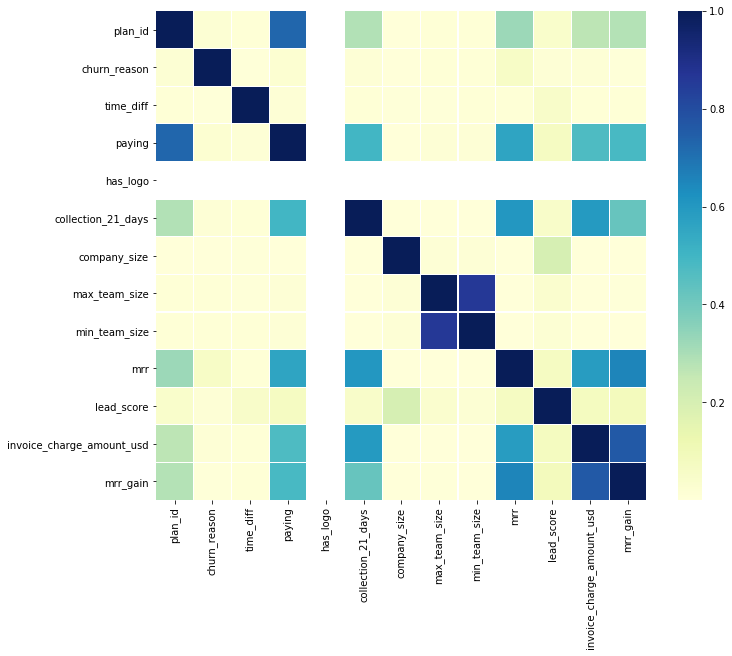

In [413]:
corrmat = z2.select_dtypes('number').corr()
f, ax = plt.subplots(figsize = (11,9))
sns.heatmap(abs(corrmat), ax=ax, cmap='YlGnBu', linewidths= 0.1)

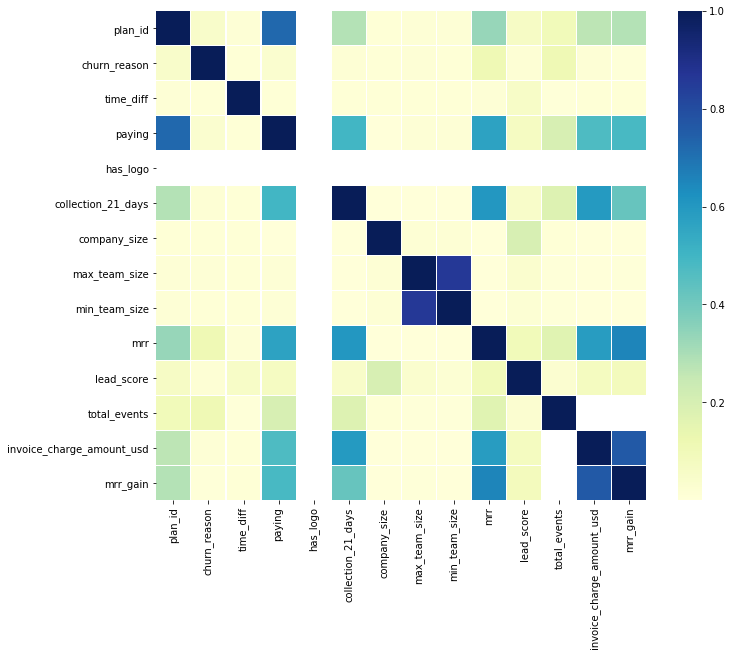

In [414]:
z=pd.concat([z1,z2],sort=False)
corrmat = z.select_dtypes('number').corr()
f, ax = plt.subplots(figsize = (11,9))
sns.heatmap(abs(corrmat), ax=ax, cmap='YlGnBu', linewidths= 0.1)